In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_excel(r'/content/mediaTRUELY_TIDIED2_v2.xlsx')

In [ ]:
pd.set_option('display.max_columns', 33)

In [ ]:
df.head(2)

,order_id,order_date,day_ordered,ship_date,ship_mode,stand_delivery_delay,days_to_ship,cust_id,cust_name,cust_type,city,state,zip,region,prod_id,prod_type,prod_sub-type,prod_name,prod_cost,prod_price,quantity_ordered,ship_cost,net_sales,cogs,gross_profit,discount_percent,discount_total,gross_profit_less_discounts,approx_defected_items,sales_issue,result_of_issue
0,CA-2011-115812,2011-09-06,Tuesday,2011-06-14,Standard Class,6,-84,BH-11710,Brosina Hoffman,Consumer,Los Angeles,California,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,4.9558,6.98,7,0.0,48.86,34.6906,14.1694,0.0,0.0,14.1694,0,date_of_shipment entry error,uncertainty & no profit
1,CA-2011-115812,2011-09-06,Tuesday,2011-06-14,Standard Class,6,-84,BH-11710,Brosina Hoffman,Consumer,Los Angeles,California,90032,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,1.3286,1.82,4,0.0,7.28,5.3144,1.9656,0.0,0.0,1.9656,0,date_of_shipment entry error,uncertainty & no profit


In [ ]:
df_cum = pd.DataFrame(df['sales_issue'].value_counts(normalize = True))

In [ ]:
df_cum['proportion'] = round((df_cum['proportion']*100),2).astype(str) + '%'

In [ ]:
df_cum = df_cum.reset_index()

In [ ]:
df_cum.rename(columns = {'sales_issue': 'Cumulative Sales Issues', 'proportion': 'Aggregated Percentage of Occurrence'})

,Cumulative Sales Issues,Aggregated Percentage of Occurrence
0,major delayed shipment,26.49%
1,none,24.89%
2,random discount,18.84%
3,date_of_shipment entry error,14.62%
4,defects,4.09%
5,defects & COGS,3.99%
6,random discount & COGS,2.34%
7,date_of_shipment entry error & likely defects,1.63%
8,major delayed shipment & COGS,1.58%
9,date_of_shipment entry error & likely defects ...,0.76%


# GOAL: Build a Supervised Model that is able to predict the probability that an order will lead to an issue in shipment (all major delayed shipments as well as date of shipment entry errors)

This version uses ALL transaction data

# Visual support as to why I feel a model centered around 'Predicting Whether a Transaction Will Lead to an Error in Shipment' is most valuable to SuperSuppliers.

In [ ]:
df.columns

Index(['order_id', 'order_date', 'day_ordered', 'ship_date', 'ship_mode',
       'stand_delivery_delay', 'days_to_ship', 'cust_id', 'cust_name',
       'cust_type', 'city', 'state', 'zip', 'region', 'prod_id', 'prod_type',
       'prod_sub-type', 'prod_name', 'prod_cost', 'prod_price',
       'quantity_ordered', 'ship_cost', 'net_sales', 'cogs', 'gross_profit',
       'discount_percent', 'discount_total', 'gross_profit_less_discounts',
       'approx_defected_items', 'sales_issue', 'result_of_issue'],
      dtype='object')

In [ ]:
df_14 = pd.DataFrame(df[['sales_issue']].value_counts(normalize = True))

In [ ]:
df_14['proportion'] = round(df_14['proportion'] * 100,2)

In [ ]:
#df_14['proportion'] = df_14['proportion'].astype(str) + '%'

In [ ]:
df_14.index

MultiIndex([(                              'major delayed shipment',),
            (                                                'none',),
            (                                     'random discount',),
            (                        'date_of_shipment entry error',),
            (                                             'defects',),
            (                                      'defects & COGS',),
            (                              'random discount & COGS',),
            (       'date_of_shipment entry error & likely defects',),
            (                       'major delayed shipment & COGS',),
            ('date_of_shipment entry error & likely defects & COGS',),
            (                 'date_of_shipment entry error & COGS',),
            (                                                'COGS',),
            (                           'delayed same day delivery',)],
           names=['sales_issue'])

In [ ]:
df_14 = df_14.reset_index()

In [ ]:
df_14.rename(columns = {'sales_issue': 'Sales Issues (2014)', 'proportion': 'Percentages'}, inplace = True)

In [ ]:
df_14.set_index('Sales Issues (2014)')

,Percentages
Sales Issues (2014),
major delayed shipment,26.49
none,24.89
random discount,18.84
date_of_shipment entry error,14.62
defects,4.09
defects & COGS,3.99
random discount & COGS,2.34
date_of_shipment entry error & likely defects,1.63
major delayed shipment & COGS,1.58


In [ ]:
filt = df_14['Sales Issues (2014)'].str.contains('delayed') | df_14['Sales Issues (2014)'].str.contains('error')

df_ship = df_14.loc[filt, ['Sales Issues (2014)', 'Percentages']].set_index('Sales Issues (2014)')

In [ ]:
cumulative_percentage = df_ship['Percentages'].sum()

In [ ]:
 total_ship = pd.DataFrame({'Sales Issues (2014)': ['Total Shipment Issues'], 'Percentages': [cumulative_percentage]}).set_index('Sales Issues (2014)')

In [ ]:
filt = ~(df_14['Sales Issues (2014)'].str.contains('delayed')) & ~(df_14['Sales Issues (2014)'].str.contains('error'))
other_issues = df_14.loc[filt].set_index('Sales Issues (2014)')

In [ ]:
sales_descriptions = pd.concat([total_ship, other_issues])

In [ ]:
sales_descriptions

,Percentages
Sales Issues (2014),
Total Shipment Issues,45.69
none,24.89
random discount,18.84
defects,4.09
defects & COGS,3.99
random discount & COGS,2.34
COGS,0.15


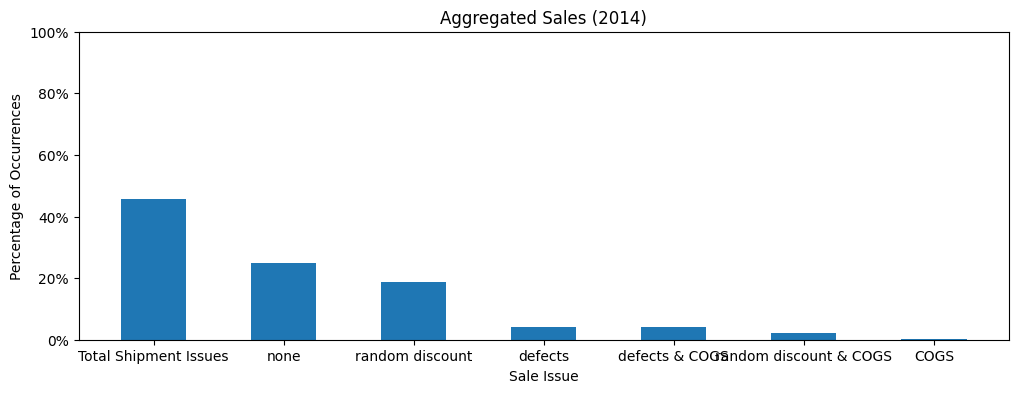

In [ ]:
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize = (12,4))
ax.bar(sales_descriptions.index, sales_descriptions['Percentages'], width = 0.5)
ax.set(title = "Aggregated Sales (2014)", xlabel = 'Sale Issue', ylabel = 'Percentage of Occurrences')
ax.set_ylim(ymax = 100)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [ ]:
sales_descriptions['Percentages'] = sales_descriptions['Percentages'].astype(str) + '%'

In [ ]:
sales_descriptions

Creating a binary field for 'shipment issue'

In [ ]:
df['shipment_issue?'] = np.nan

In [ ]:
filt = (df['sales_issue'].str.contains('delayed') | (df['sales_issue'].str.contains('error')))

df.loc[filt,'shipment_issue?'] = 1

In [ ]:
df['shipment_issue?'].fillna(0, inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   order_id               9994 non-null   object        
 1   order_date             9994 non-null   datetime64[ns]
 2   day_ordered            9994 non-null   object        
 3   ship_date              9994 non-null   datetime64[ns]
 4   ship_mode              9994 non-null   object        
 5   stand_delivery_delay   9994 non-null   int64         
 6   days_to_ship           9994 non-null   int64         
 7   cust_id                9994 non-null   object        
 8   cust_name              9994 non-null   object        
 9   cust_type              9994 non-null   object        
 10  city                   9994 non-null   object        
 11  state                  9994 non-null   object        
 12  zip                    9994 non-null   int64         
 13  reg

In [ ]:
filt = (df['shipment_issue?'] == 0.0)

df.loc[filt, 'shipment_issue?'] = df.loc[filt, 'shipment_issue?'].replace(0.0, 0)

In [ ]:
df['shipment_issue?'] = df['shipment_issue?'].astype(int)

In [ ]:
df.head()

,order_id,order_date,day_ordered,ship_date,ship_mode,stand_delivery_delay,days_to_ship,cust_id,cust_name,cust_type,city,state,zip,region,prod_id,prod_type,prod_sub-type,prod_name,prod_cost,prod_price,quantity_ordered,ship_cost,gross_rev,cogs,gross_profit,discount_percent,discount_total,net_sales,approx_defected_items,sales_issue,result_of_issue,shipment_issue?
0,CA-2011-115812,2011-09-06,Tuesday,2011-06-14,Standard Class,6,-84,BH-11710,Brosina Hoffman,Consumer,Los Angeles,California,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,4.9558,6.9800,7,0.0,48.8600,34.6906,14.1694,0.0,0.0000,14.1694,0,date_of_shipment entry error,uncertainty & no profit,1
1,CA-2011-115812,2011-09-06,Tuesday,2011-06-14,Standard Class,6,-84,BH-11710,Brosina Hoffman,Consumer,Los Angeles,California,90032,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,1.3286,1.8200,4,0.0,7.2800,5.3144,1.9656,0.0,0.0000,1.9656,0,date_of_shipment entry error,uncertainty & no profit,1
2,CA-2011-115812,2011-09-06,Tuesday,2011-06-14,Standard Class,6,-84,BH-11710,Brosina Hoffman,Consumer,Los Angeles,California,90032,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,136.0728,181.4304,6,0.0,1088.5824,816.4368,272.1456,0.2,181.4304,90.7152,1,date_of_shipment entry error & likely defects,uncertainty & no profit,1
3,CA-2011-115812,2011-09-06,Tuesday,2011-06-14,Standard Class,6,-84,BH-11710,Brosina Hoffman,Consumer,Los Angeles,California,90032,West,OFF-BI-10003910,Office Supplies,Binders,DXL Angle-View Binders with Locking Rings by S...,4.2405,7.4016,3,0.0,22.2048,12.7215,9.4833,0.2,3.7008,5.7825,0,date_of_shipment entry error,uncertainty & no profit,1
4,CA-2011-115812,2011-09-06,Tuesday,2011-06-14,Standard Class,6,-84,BH-11710,Brosina Hoffman,Consumer,Los Angeles,California,90032,West,OFF-AP-10002892,Office Supplies,Appliances,Belkin F5C206VTEL 6 Outlet Surge,16.0860,22.9800,5,0.0,114.9000,80.4300,34.4700,0.0,0.0000,34.4700,0,date_of_shipment entry error,uncertainty & no profit,1


# First aim to see how model turns out using Logistic Regression

creating dummy variables to use some of the qualitative variables as predictors

In [ ]:
df_log_reg = df.copy()

In [ ]:
df_log_reg['month_ordered'] = df_log_reg['order_date'].dt.month_name()

In [ ]:
df_log_reg.head(2)

,order_id,order_date,day_ordered,ship_date,ship_mode,stand_delivery_delay,days_to_ship,cust_id,cust_name,cust_type,city,state,zip,region,prod_id,prod_type,prod_sub-type,prod_name,prod_cost,prod_price,quantity_ordered,ship_cost,gross_rev,cogs,gross_profit,discount_percent,discount_total,net_sales,approx_defected_items,sales_issue,result_of_issue,shipment_issue?,month_ordered
0,CA-2011-115812,2011-09-06,Tuesday,2011-06-14,Standard Class,6,-84,BH-11710,Brosina Hoffman,Consumer,Los Angeles,California,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,4.9558,6.98,7,0.0,48.86,34.6906,14.1694,0.0,0.0,14.1694,0,date_of_shipment entry error,uncertainty & no profit,1,September
1,CA-2011-115812,2011-09-06,Tuesday,2011-06-14,Standard Class,6,-84,BH-11710,Brosina Hoffman,Consumer,Los Angeles,California,90032,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,1.3286,1.82,4,0.0,7.28,5.3144,1.9656,0.0,0.0,1.9656,0,date_of_shipment entry error,uncertainty & no profit,1,September


creating integer values to represet day of week and month ordered

In [ ]:
def get_month_int(month):
  d = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
  for k, v in d.items():
    if month == k:
      return v

#print(get_month_int('January'))

df_log_reg['month_ordered'] = df_log_reg['month_ordered'].apply(get_month_int)

In [ ]:
def get_day_int(day):
  d = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
  for k, v in d.items():
    if day == k:
      return v

df_log_reg['day_ordered'] = df_log_reg['day_ordered'].apply(get_day_int)

In [ ]:
df_log_reg.head(2)

,order_id,order_date,day_ordered,ship_date,ship_mode,stand_delivery_delay,days_to_ship,cust_id,cust_name,cust_type,city,state,zip,region,prod_id,prod_type,prod_sub-type,prod_name,prod_cost,prod_price,quantity_ordered,ship_cost,gross_rev,cogs,gross_profit,discount_percent,discount_total,net_sales,approx_defected_items,sales_issue,result_of_issue,shipment_issue?,month_ordered
0,CA-2011-115812,2011-09-06,2,2011-06-14,Standard Class,6,-84,BH-11710,Brosina Hoffman,Consumer,Los Angeles,California,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,4.9558,6.98,7,0.0,48.86,34.6906,14.1694,0.0,0.0,14.1694,0,date_of_shipment entry error,uncertainty & no profit,1,9
1,CA-2011-115812,2011-09-06,2,2011-06-14,Standard Class,6,-84,BH-11710,Brosina Hoffman,Consumer,Los Angeles,California,90032,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,1.3286,1.82,4,0.0,7.28,5.3144,1.9656,0.0,0.0,1.9656,0,date_of_shipment entry error,uncertainty & no profit,1,9


dropped columns that aren't relevant to the predictive model and some columns that I believe will prevent the model from performing well on unseen data (in other words, dimensionality reduction to only include variables that are most relevant to predicting whether the transacion leads to 'shipment issues' don't cause the model to overfit to noise)



In [ ]:
# adding to drop 'cust_name', 'region', 'prod_type

In [ ]:
df_log_reg.drop(columns = ['order_id', 'order_date', 'ship_date', 'days_to_ship', 'cust_id', 'prod_id', 'sales_issue', 'result_of_issue'], inplace = True)

In [ ]:
#disregard columns ['order_id', 'order_date', 'ship_date', 'cust_id', 'zip', 'prod_id', 'sales_issue', 'result_of_issue']

In [ ]:
df_log_reg = pd.get_dummies(df_log_reg, columns = ['ship_mode', 'cust_name', 'cust_type', 'city', 'state', 'region', 'prod_type', 'prod_sub-type', 'prod_name'] )

In [ ]:
df_log_reg.head(2)

,day_ordered,stand_delivery_delay,zip,prod_cost,prod_price,quantity_ordered,ship_cost,gross_rev,cogs,gross_profit,discount_percent,discount_total,net_sales,approx_defected_items,shipment_issue?,month_ordered,...,prod_name_Xerox WorkCentre 6505DN Laser Multifunction Printer,prod_name_Xiaomi Mi3,"prod_name_XtraLife ClearVue Slant-D Ring Binder, White, 3""",prod_name_XtraLife ClearVue Slant-D Ring Binders by Cardinal,prod_name_Zebra GK420t Direct Thermal/Thermal Transfer Printer,prod_name_Zebra GX420t Direct Thermal/Thermal Transfer Printer,prod_name_Zebra ZM400 Thermal Label Printer,prod_name_Zebra Zazzle Fluorescent Highlighters,prod_name_Zipper Ring Binder Pockets,prod_name_i.Sound Portable Power - 8000 mAh,prod_name_iHome FM Clock Radio with Lightning Dock,"prod_name_iKross Bluetooth Portable Keyboard + Cell Phone Stand Holder + Brush for Apple iPhone 5S 5C 5, 4S 4",prod_name_iOttie HLCRIO102 Car Mount,prod_name_iOttie XL Car Mount,prod_name_invisibleSHIELD by ZAGG Smudge-Free Screen Protector,prod_name_netTALK DUO VoIP Telephone Service
0,2,6,90032,4.9558,6.98,7,0.0,48.86,34.6906,14.1694,0.0,0.0,14.1694,0,1,9,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2,6,90032,1.3286,1.82,4,0.0,7.28,5.3144,1.9656,0.0,0.0,1.9656,0,1,9,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
#get dummies for ['ship_mode', 'cust_name', 'cust_type', 'city', 'state', 'region', 'prod_type', 'prod_sub-type', 'prod_name']

In [ ]:
indep_vars = [i for i in df_log_reg.columns if i != 'shipment_issue?']
dep_vars = 'shipment_issue?'
x = df_log_reg[indep_vars]
y = df_log_reg[dep_vars]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter = 1000)
model.fit(x_train, y_train)
print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

0.5973733583489681
0.607303651825913


Promising that testing is better than training. Shows model is learning

# Attemp with CARTS


In [ ]:
from sklearn.tree import DecisionTreeClassifier

manual dimensionality reduction

In [ ]:
model = DecisionTreeClassifier(max_depth = 4, min_samples_split= 25)
model.fit(x_train, y_train)
print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

0.6323952470293934
0.632816408204102




```
# This is formatted as code
```

Better!

In [ ]:
y_train.value_counts()

shipment_issue?
0    4350
1    3645
Name: count, dtype: int64

[Text(0.45588235294117646, 0.9, 'stand_delivery_delay <= 1.5\ngini = 0.496\nsamples = 7995\nvalue = [4350, 3645]\nclass = c'),
 Text(0.23529411764705882, 0.7, 'cust_name_Alice McCarthy <= 0.5\ngini = 0.075\nsamples = 434\nvalue = [417, 17]\nclass = c'),
 Text(0.17647058823529413, 0.5, 'cust_name_Karen Ferguson <= 0.5\ngini = 0.059\nsamples = 430\nvalue = [417, 13]\nclass = c'),
 Text(0.11764705882352941, 0.3, 'cust_name_Liz Pelletier <= 0.5\ngini = 0.05\nsamples = 428\nvalue = [417, 11]\nclass = c'),
 Text(0.058823529411764705, 0.1, 'gini = 0.041\nsamples = 426\nvalue = [417, 9]\nclass = c'),
 Text(0.17647058823529413, 0.1, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = l'),
 Text(0.23529411764705882, 0.3, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = l'),
 Text(0.29411764705882354, 0.5, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]\nclass = l'),
 Text(0.6764705882352942, 0.7, 'day_ordered <= 6.5\ngini = 0.499\nsamples = 7561\nvalue = [3933, 3628]\nclass = c'),
 Text(0.47058823529411

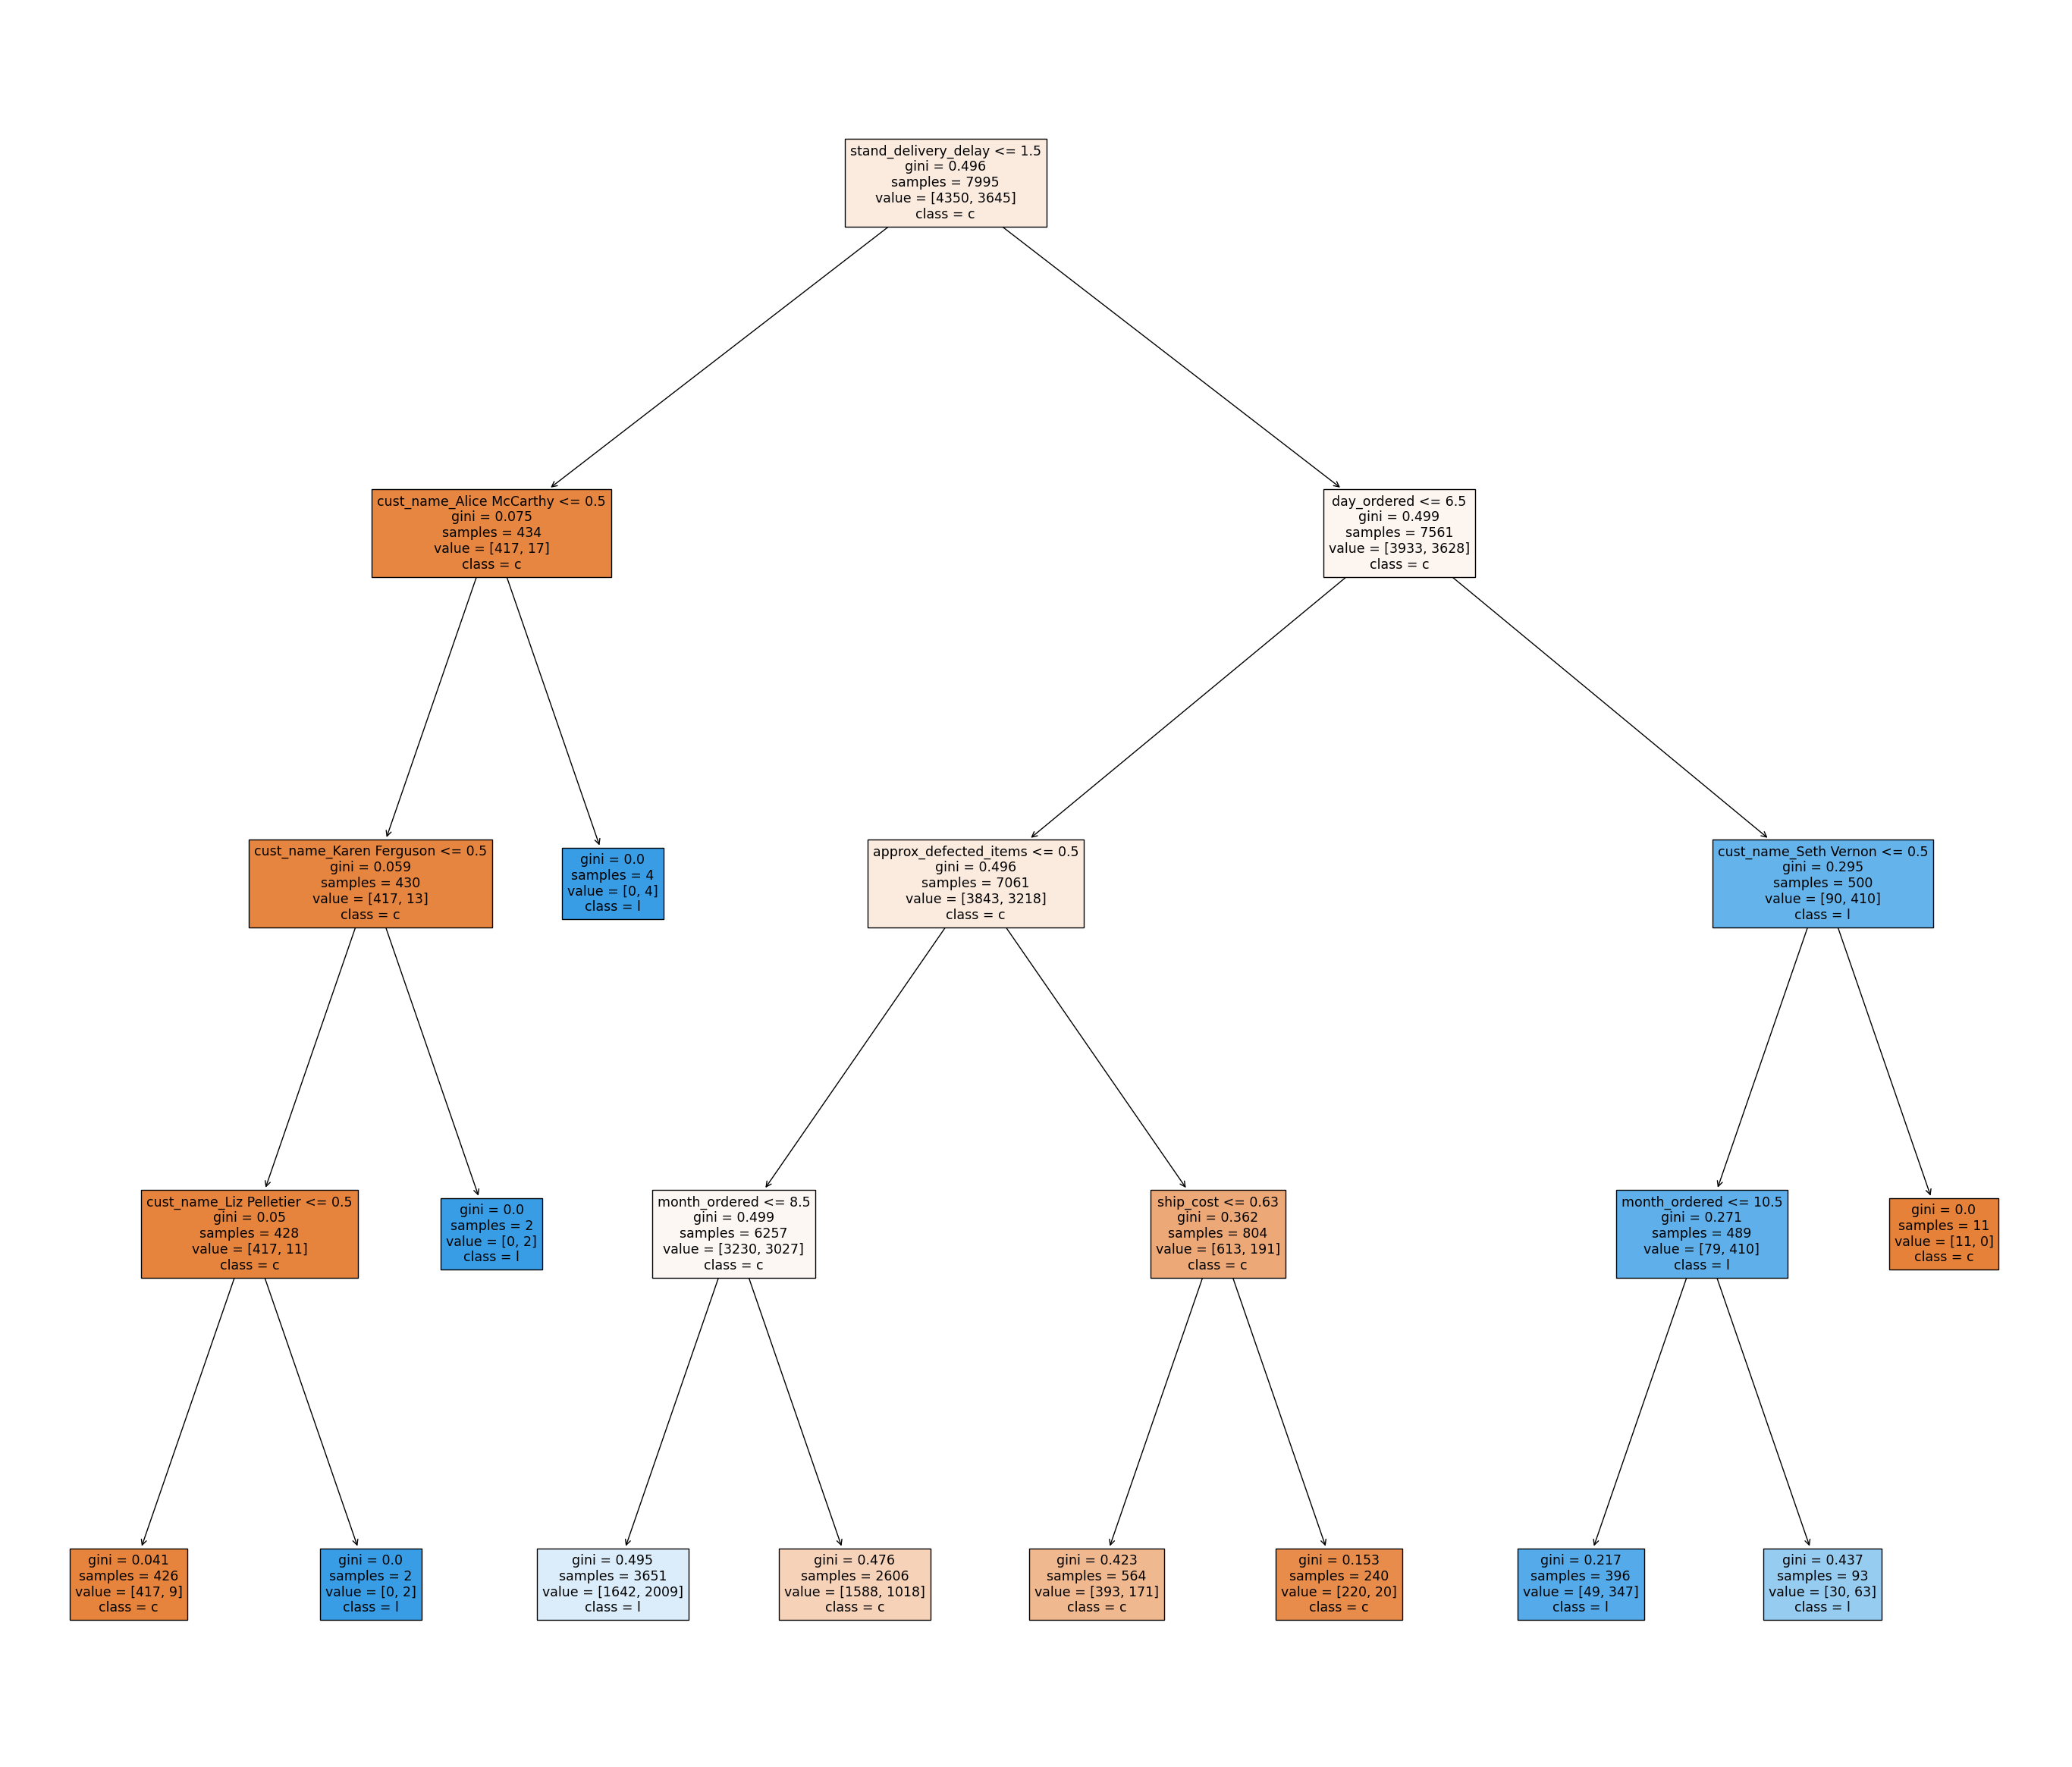

In [ ]:
from sklearn import tree
fig = plt.figure(figsize = (35, 30))
tree.plot_tree(model, feature_names = x_train.columns, class_names = 'class', filled = True)

In [ ]:
preds = model.predict_proba(x_test)
preds = np.array([i[1] for i in preds])

Certainty of model that the sample does not/does belong to a recognized 'issue in shipment'

In [ ]:
preds[0:10]

array([0.5502602 , 0.        , 0.5502602 , 0.30319149, 0.5502602 ,
       0.5502602 , 0.5502602 , 0.39063699, 0.39063699, 0.5502602 ])

In [ ]:
import seaborn as sns

# Visualization of how well the model is able to distinguing between categorizing samples that do vs dont have issues with shipment

<ipython-input-46-cee9cf5c8b8e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(preds[y_test==0], hist = False, kde=True, label = 'No Issue with Shipment')
<ipython-input-46-cee9cf5c8b8e>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(preds[y_test==1], hist = False, kde = Tr

(0.0, 1.0)

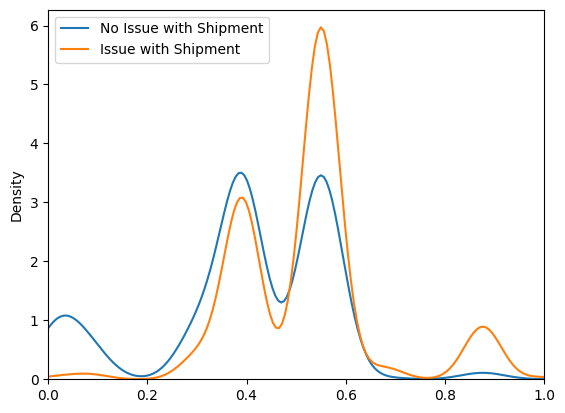

In [ ]:
sns.distplot(preds[y_test==0], hist = False, kde=True, label = 'No Issue with Shipment')
sns.distplot(preds[y_test==1], hist = False, kde = True, label = 'Issue with Shipment')
plt.legend()
plt.xlim(0,1)

# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, columns = ['Predicted 0','Predicted 1'], index = ['True 0', 'True 1'])
cm

,Predicted 0,Predicted 1
True 0,653,425
True 1,309,612


WITH THE TESTING DATA

653 True Negatives: The Model Predicted that the transaction didn't have an issue with shipment and the transaction correctly didn't have an issue with shipment.

425 False Positives: The model incorrectly predicted that 8 of the transactions contained an issue with shipment, when they in fact did not.

309 False Negatives: The Model incorrectly predicted 10 transactions did not have an issue with shipment, when they in fact did.

612 True Positives: The model correctly predicted 279 transactions that did contain issues with shipment.

# Precision & Recall

In [ ]:
precision = cm.loc['True 1', 'Predicted 1']/cm['Predicted 1'].sum()
recall = cm.loc['True 1', 'Predicted 1']/cm.loc['True 1'].sum()
print('Recall: ', str(round(100*recall, 2))+'%')
print('Precision: ', str(round(100*precision,2)) + '%')

Recall:  66.45%
Precision:  59.02%
